In [ ]:
# !pip install demoji

In [ ]:
# !pip install textblob

In [ ]:
# !pip install afinn

In [ ]:
# !pip install wordcloud

In [ ]:
# !pip install textblob-fr

In [ ]:
# !pip install plotly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import re
import matplotlib
import plotly.express as px
import seaborn as sns
import datetime
import random
from afinn import Afinn
from datetime import *
import demoji
from wordcloud import WordCloud
from textblob import TextBlob
from textblob import TextBlob, Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
import nltk
from nltk.corpus import stopwords
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [2]:
# nltk.download('stopwords')
# nltk.download('punkt')

# Introduction

# Data Wrangling

In [3]:
df_tweets = pd.read_csv("~/work/projetpy/csv_tweets/tweets_vaccins.csv")

Un même tweet peut être posté par le même auteur à des heures différentes. La cellule ci-dessous permet de supprimer ces tweets dupliqués qui ont des valeurs communes de *texte* et *type_vaccin*. Ceratins tweets citent plus d'un vaccin, leurs repétitions selon *texte* et *type_vaccin* est légitime et ne seront pas pris en compte dans la suppression.

In [4]:
df_tweets["datetime"] = df_tweets["date"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

df_tweets["date"] = df_tweets["datetime"].apply(datetime.date)

In [5]:
df_tweets.drop_duplicates(subset = ["texte", "type_vaccin"], keep = 'first', inplace=True, ignore_index = True)

In [6]:
df_tweets.head(5)

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de ...",tweet,pfizer,2021-03-01 00:32:26
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01
2,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,janssen,2021-03-01 08:42:07
3,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,moderna,2021-03-01 08:42:07
4,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,pfizer,2021-03-01 08:42:07


In [7]:
df_tweets.shape

(6005, 9)

Ainsi, 6005 tweets ont été requètés via l'API sur la période de 01 mars 2021 au 26 décembre 2021.

### Nettoyage des données textuelles

Les tweets sont des objets "sales" et cela rend dificile leur manipulation. Pour la suite, il faudra les nettoyer et la foncttion transforme définie à cet effet sert à supprimer les caractères spéciaux, les émojis, les ponctuations, à tranformer les majuscules en minuscule, etc...

In [8]:
def transforme(texte):
    texte = texte.lower() # mettre les mots en minuscule
    #retirer les liens
    for item in re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+").findall(texte):
        texte=texte.replace(item, "")
    # enlever le retour à la ligne
    texte = texte.replace("\n", " ").replace("\r", "") 
    # supprimer ",", "!", "?", "%", "(",")","/",'"', "$","£", "_", "-", "+", "*", "µ", ":","&,"§" 
    texte = re.sub(r"[,\!\?\%\(\)\/\"\$\£\-\+\*\µ,\:\&\§]", " ", texte) 
    # retirer les hashtags #
    for item in re.compile("([#]\w+)").findall(texte):
        texte=texte.replace(item, "")
    # retirer les apostrophes '
    for item in re.compile("([\’])").findall(texte):
        texte=texte.replace(item, " ")
    for item in re.compile("([\'])").findall(texte):
        texte=texte.replace(item, " ")
    # retirer les points de suspension
    for item in re.compile("([.]{1,5})").findall(texte):
        texte=texte.replace(item, "") 
    # retirer les personnes tagées
    for item in re.compile("([@]\w+)").findall(texte):
        texte=texte.replace(item, "")
    # retirer les adresses mail
    for item in re.findall('\S+@\S+', texte) :
        texte=texte.replace(item, "")
    # retire les mots contenant des chiffres
    texte = re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", texte)
    # retirer les emojis
    for item in demoji.findall(texte):
        texte=texte.replace(item,"")
    return texte

In [9]:
df_tweets["texte_propre"] = df_tweets["texte"].apply(lambda x: transforme(x))
df_tweets.head()

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime,texte_propre
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de ...",tweet,pfizer,2021-03-01 00:32:26,au japon on refuse le don de sang de personn...
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01,tragique
2,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,janssen,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...
3,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,moderna,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...
4,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,pfizer,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...


Pour créer les wordclouds, la liste  les mots vides du texte doivent être mis à jour spécifiquement pour le domaine du texte.En effet pour des tweets sur les vaccins Covid certains mots comme *vaccin*, etc... pourraient ne pas avoir d'importance pour l'analyse.

In [10]:
# Pour enlever les stopwords
stop_words = list(stopwords.words('french'))

for x in ['vaccin', 'vaccins', 'vaccination', 'comme', 'alors']:
    stop_words.append(x)
    
# stop_words

### Calcul du sentiment d'un tweet à partir de la polarité de Textblob

In [11]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

In [12]:
def tweet_polarite(text):
    return tb(text).sentiment[0]

In [13]:
def tweet_label_car(text):
    if tweet_polarite(text) > 0 :
        return "positif"
    if tweet_polarite(text) < 0 :
        return "negatif"
    return "neutre"

In [14]:
def tweet_label(text):
    if tweet_polarite(text) > 0 :
        return 1
    if tweet_polarite(text) < 0 :
        return -1
    return 0

In [15]:
df_tweets["score_polarite"] = df_tweets["texte_propre"].apply(tweet_polarite)
df_tweets["label_car"] = df_tweets["texte_propre"].apply(tweet_label_car)
df_tweets["label"] = df_tweets["texte_propre"].apply(tweet_label)

In [16]:
# df_tweets.head()

### Création de features

Pour bien mener la modélisation, nous extrayons des tweets certains variables qui nous semble être important comme par exemple les variables binaires renseignant sur le type de vaccin, le nombre de hashtags, de ponctuation, ...

In [17]:
# Création des 'dummy" variables
dummy_df = pd.get_dummies(df_tweets.type_vaccin, prefix="vaccin", prefix_sep='_', drop_first=False)
df_tweets[dummy_df.columns] = dummy_df

In [18]:
def decompte_hashtags(text):
    exp_match = re.compile("([#]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_hashtags"] = df_tweets["texte"].apply(lambda x : decompte_hashtags(x))

In [19]:
def decompte_tags(text):
    exp_match = re.compile("([@]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_tags"] = df_tweets["texte"].apply(lambda x : decompte_tags(x))

In [20]:
def decompte_exclamation(text):
    exp_match = re.compile("(\w?\s?[!])")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_exclamation"] = df_tweets["texte"].apply(lambda x : decompte_exclamation(x))

In [21]:
def decompte_mails(text):
    exp_match = re.compile("(\w+[@]\w+[.]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_mails"] = df_tweets["texte"].apply(lambda x : decompte_mails(x))

In [22]:
def decompte_interrogation(text):
    exp_match = re.compile("(\w?\s?[?])")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_interrogation"] = df_tweets["texte"].apply(lambda x : decompte_interrogation(x))

In [23]:
def decompte_mot_maj(text):
    exp_match = re.compile("([A-Z][A-Z]+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_maj"] = df_tweets["texte"].apply(lambda x : decompte_mot_maj(x))

In [24]:
df_tweets.head()

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime,texte_propre,...,vaccin_astrazeneca,vaccin_janssen,vaccin_moderna,vaccin_pfizer,nbre_hashtags,nbre_tags,nbre_exclamation,nbre_mails,nbre_interrogation,nbre_maj
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de ...",tweet,pfizer,2021-03-01 00:32:26,au japon on refuse le don de sang de personn...,...,0,0,0,1,1,1,0,0,1,2
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01,tragique,...,0,0,0,1,0,2,0,0,0,0
2,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,janssen,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,...,0,1,0,0,0,2,0,0,0,1
3,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,moderna,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,...,0,0,1,0,0,2,0,0,0,1
4,2021-03-01,1366307752096768000,2,0,socarre,@thierrycogne @dc_morel Vaccinons en pharmacie...,tweet,pfizer,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins ...,...,0,0,0,1,0,2,0,0,0,1


In [25]:
print("Ainsi, {:1d} tweets ont pu être requetés et {:1d} variables construites. La dicionnaire de données est le suivante".format(df_tweets.shape[0], df_tweets.shape[1]))

Ainsi, 6005 tweets ont pu être requetés et 23 variables construites. La dicionnaire de données est le suivante


Le dictionnaire de donnée est le suivant
+ date
+ id
+ nbre_like
+ nbre_retweet
+ screenName
+ texte
+ type
+ type_vaccin
+ datetime
+ texte_propre
+ score_polarite
+ label_car
+ label
+ vaccin_astrazeneca
+ vaccin_janssen
+ vaccin_moderna
+ vaccin_pfizer
+ nbre_hashtags
+ nbre_tags
+ nbre_exclamation
+ nbre_mails
+ nbre_interrogation
+ nbre_maj

# Explatory Data Analysis

### Stats descriptives

In [26]:
df_tweets.describe()

,id,nbre_like,nbre_retweet,score_polarite,label,vaccin_astrazeneca,vaccin_janssen,vaccin_moderna,vaccin_pfizer,nbre_hashtags,nbre_tags,nbre_exclamation,nbre_mails,nbre_interrogation,nbre_maj
count,6.005000e+03,6005.000000,6005.000000,6005.000000,6005.000000,6005.000000,6005.000000,6005.000000,6005.000000,6005.000000,6005.000000,6005.000000,6005.0,6005.000000,6005.000000
mean,1.409209e+18,8.904413,2.973522,0.071004,0.350375,0.230475,0.026478,0.168693,0.574355,1.050958,1.230808,0.345379,0.0,0.264613,1.281266
std,3.169649e+16,109.422451,34.281982,0.194016,0.792706,0.421172,0.160565,0.374512,0.494482,2.256474,1.626423,0.898003,0.0,0.726913,1.903394
min,1.366185e+18,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,1.380763e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,1.404481e+18,1.000000,0.000000,0.033333,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000
75%,1.430842e+18,2.000000,0.000000,0.160000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.0,0.000000,2.000000
max,1.475089e+18,6036.000000,1879.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,24.000000,23.000000,12.000000,0.0,10.000000,28.000000


Un apercu sur la colonne *nbre_mails*, qui a une valeur minimale et maximale de 0, montre qu'elle est sans intéret pour la suite.

In [27]:
df_tweets = df_tweets.drop("nbre_mails", axis=1)

In [28]:
df_tweets.groupby("type_vaccin")["id"].count()

type_vaccin
astrazeneca    1384
janssen         159
moderna        1013
pfizer         3449
Name: id, dtype: int64

Text(0.5, 1.0, 'Répartition des tweets selon le type de vaccin')

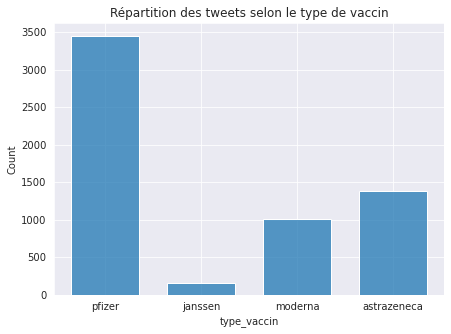

In [29]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
sns.histplot(df_tweets, x="type_vaccin",  shrink=0.7)
plt.title("Répartition des tweets selon le type de vaccin")

Pfizer était le vaccin le plus populaire puis que environ 3500 tweets l'ont cité. Il est suivi de AstraZeneca avec 1384 mentions et Moderna avec environ 1000 mentions. Janssen est très faiblement représenté avec 159 tweets. 

In [30]:
df_tweets.groupby("label_car")["id"].count()

label_car
negatif    1203
neutre     1495
positif    3307
Name: id, dtype: int64

Text(0.5, 1.0, 'Répartition des tweets par label de sentiment')

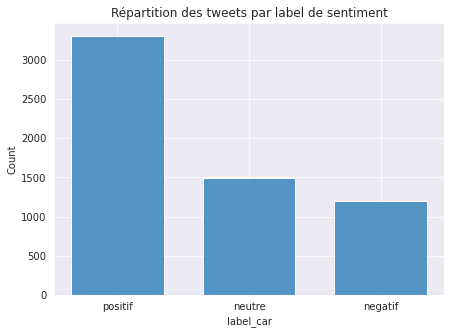

In [31]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
# customPalette = sns.set_palette(sns.diverging_palette(150, 10, n=3))

sns.histplot(df_tweets.sort_values("label_car", ascending=False), x="label_car",  shrink=0.7)# , palette=customPalette)
plt.title("Répartition des tweets par label de sentiment")

Parmi tous les tweets, environ la moitié ont été désignés par TextBlob comme positifs en termes de sentiment (polarité = > 1), l'autre moitié étant constituée de 1203 tweets négatifs (polarité < 0,0) et de 1495 tweets neutres (polarité = 0).

In [32]:
df_tweets.groupby([ "type_vaccin", "label_car"])["id"].count()

type_vaccin  label_car
astrazeneca  negatif       298
             neutre        322
             positif       764
janssen      negatif        34
             neutre         37
             positif        88
moderna      negatif       210
             neutre        249
             positif       554
pfizer       negatif       661
             neutre        887
             positif      1901
Name: id, dtype: int64

<Figure size 720x504 with 0 Axes>

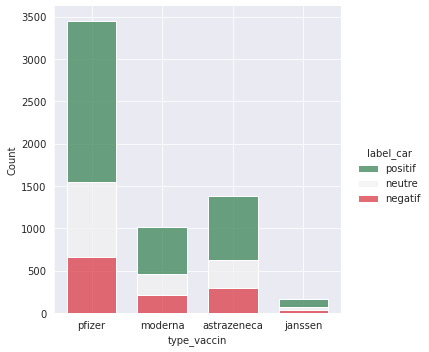

In [33]:
plt.figure(figsize=(10, 7))
# sns.color_palette("Spectral", as_cmap=True)
cpalette = sns.diverging_palette(140, 10, n=3)
sns.displot(df_tweets.sort_values("label_car", ascending=False), x="type_vaccin", hue="label_car", multiple="stack", shrink=0.7, palette=cpalette)

Pour tous les types de vaccins, les tweets "positifs"sont les plus représentés suivi des tweets neutres et enfin des tweets de label négatif. La population a apprécié tous les types de vaccin en moyenne. 

### Analyse temporelle

Dans cette partie, nous verrons si nous pouvons explorer des tendances par rapport au temps.   
Premièrement, il est utile de visualiser la distribution temporelle de tous les tweets dans l'ensemble de données.

Text(0.5, 1.0, 'Fréquence des tweets par rapport au temps')

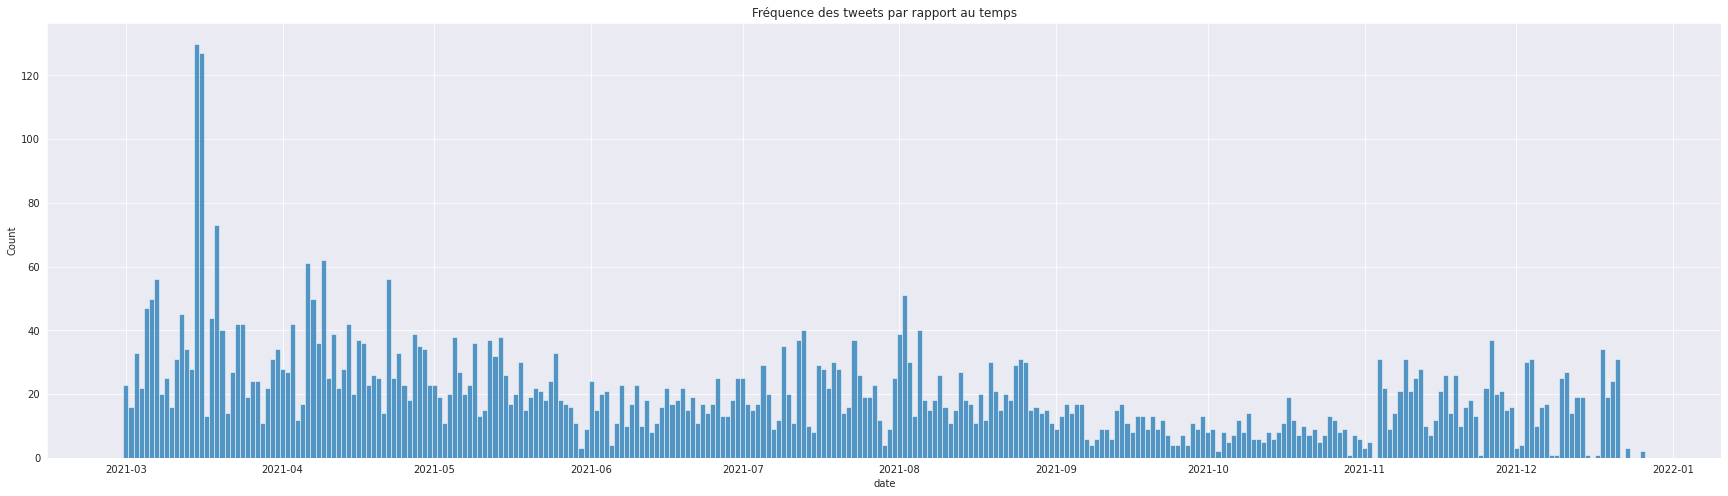

In [34]:
plt.figure(figsize=(30, 8))
sns.set_style('darkgrid')
sns.histplot(df_tweets, x="date")
plt.title("Fréquence des tweets par rapport au temps")

In [35]:
df_date = df_tweets.groupby(['date']).agg(np.nanmean).reset_index()
df_date['nbre_tweet'] = df_tweets.groupby(['date']).count().reset_index()['id']
df_date = df_date[['date', 'nbre_tweet', 'score_polarite', 'nbre_like']]
df_date["score_polarite"] = df_date["score_polarite"].astype(float)
# df_date['nbre_tweet']

In [36]:
# plt.figure(figsize=(30, 8))
# plot = plt.scatter(df_date.index, df_date['nbre_tweet'], c=df_date['score_polarite'], cmap='coolwarm')
# plt.clf()
# plt.colorbar(plot)
# ax = sns.barplot(x=df_date.index, y=df_date['nbre_tweet'], hue=df_date['score_polarite'], palette='coolwarm', dodge=False)
# ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(prune='both', nbins=11))
# ax.set(xlabel="Date",
#       ylabel="nombre_tweets",
#       title="Score de polarité moyen pour les tweets agrégés par date")
# ax.legend_.remove()

### Visualisation avec WordCloud

On se propose ici de visualiser les wordclouds selon le sentiment et selon le vaccin.

In [37]:
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

In [38]:
def plot_wordcloud_label() :
    # joindre les tweets en une chaine de caractere par type de sentiment
    df_pos = df_tweets[df_tweets['label']==1]
    mots_pos = ' '.join(df_pos['texte_propre'])
    
    df_neg = df_tweets[df_tweets['label']==-1]
    mots_neg = ' '.join(df_neg['texte_propre'])
    
    df_neu = df_tweets[df_tweets['label']==0]
    mots_neu = ' '.join(df_neu['texte_propre'])
    
    fig, axes = plt.subplots(1,3, figsize=(25,25))
    
    wordcloud_neg = WordCloud(stopwords=stop_words,
                          background_color='white',
                          collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Reds'
                         ).generate(mots_neg)
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Sentiment négatif")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(stopwords=stop_words,
                          background_color='white',
                          collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Greens'
                         ).generate(mots_neu)
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Sentiment neutre")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(stopwords=stop_words,
                          background_color='white', collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Greens'
                         ).generate(mots_pos)
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Sentiment positif")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();
    # return fig

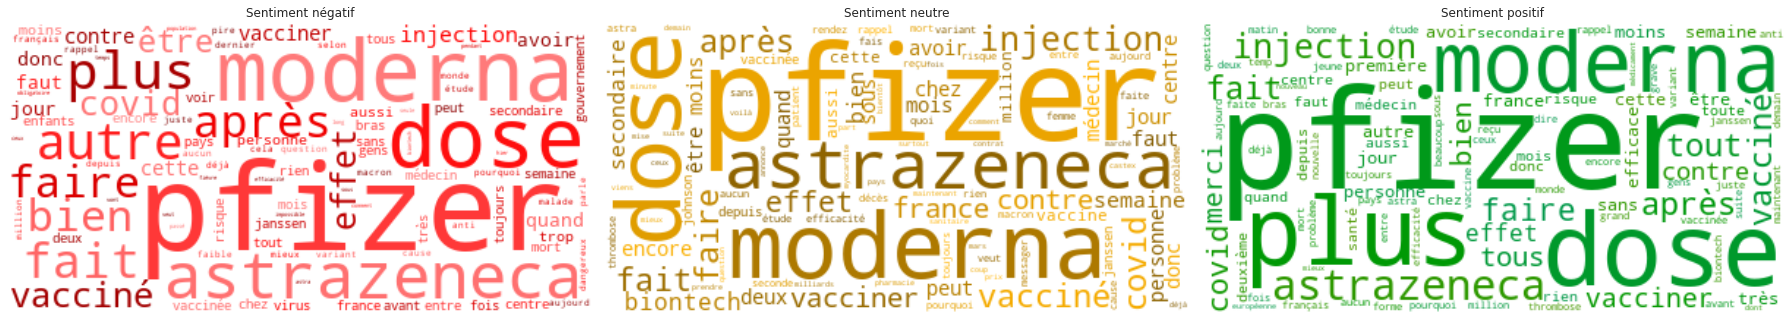

In [39]:
plot_wordcloud_label()

In [40]:
def plot_wordcloud_vaccin(vaccin) :
    df_cloud = df_tweets[df_tweets['type_vaccin']==vaccin] 
    # join tweets to a single string
    words = ' '.join(df_cloud['texte_propre'])

    wordcloud = WordCloud(stopwords=stop_words,
                          background_color='white',
                          width=2000, height=1500, max_words=100,
                          collocations=False, collocation_threshold=1, min_word_length=5,
                         ).generate(words)

    plt.figure(1,figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

# Modelling

Cette section concerne la modélisation où une analyse en composante principale et un modèle d'apprentissage supervisé seront implémentés. 

### Analyse en composante principale ACP

In [ ]:
X = df_tweets[[ "label", "nbre_hashtags", "nbre_tags", "nbre_exclamation", "nbre_interrogation", "nbre_maj"]]
X # "label",

In [ ]:
#nombre d'observations
n = X.shape[0]
#nombre de variables
p = X.shape[1]

In [ ]:
# instanciation
sc = StandardScaler()
#transformation – centrage-réduction
Z = sc.fit_transform(X)
print(Z)

In [ ]:
# verification du scaling
### moyenne
print(np.mean(Z,axis=0))

### ecart-type
print(np.std(Z,axis=0,ddof=0))

In [ ]:
# instanciation
acp = PCA(svd_solver='full')

In [ ]:
# calculs
coord = acp.fit_transform(Z)
# nombre de composantes calculées
print(acp.n_components_) # 6

In [ ]:
# variance expliquée
print(acp.explained_variance_)

In [ ]:
eigval = (n-1)/n*acp.explained_variance_
print(eigval)

In [ ]:
# scree plot
plt.plot(np.arange(1,p+1),eigval)
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.show()

In [ ]:
plt.plot(np.arange(1,p+1),np.cumsum(acp.explained_variance_ratio_))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.show()

In [ ]:
#seuils pour test des bâtons brisés
bs = 1/np.arange(p,0,-1)
bs = np.cumsum(bs)
bs = bs[::-1]

print(pd.DataFrame({'Val.Propre':eigval,'Seuils':bs}))

### Régression logistique

In [ ]:
dataframe = df_tweets[["vaccin_astrazeneca", "vaccin_janssen", "vaccin_moderna", "vaccin_pfizer", 'nbre_like', 'nbre_retweet', 'nbre_hashtags', 'nbre_tags', 'nbre_exclamation', 'nbre_interrogation', 'nbre_maj', 'label']]
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(['label'], axis=1), df_tweets.label, test_size=0.2, random_state=12344)

In [ ]:
reglog = LogisticRegression(max_iter=1000)
reglog.fit(X_train, y_train)
reglog.score(X_test, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test, reglog.predict(X_test))
conf